In [44]:
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow and tf.keras
import tensorflow as tf
# from tensorflow import keras

# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.datasets import cifar10
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten
# from tensorflow.keras import optimizers

import skimage as ski
from skimage.transform import resize
from sklearn.model_selection import train_test_split

### Convert images from pixals into data, then use pretrained model to accurately classify the stocks
- Mathematical detection algorithms are at best 84% accurate. Goal is to 
- https://www.tensorflow.org/tutorials/images/transfer_learning
- Make a requirements text file
- We do not apply data augmentation because we already have patterns classified as up or down, and flipping them would be counter intuitive

### Working with a pretrained model:
- Feature Extraction
    - Add new classifiers
- Fine-Tuning
    - Unfreeze a few of the top layers

In [141]:
tf.debugging.set_log_device_placement(True)

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [156]:
# Global Variables
BATCH_SIZE = 32
IMG_SIZE = (128, 128)

In [157]:
# Paths: For local machine
train_dir = 'C:/Users/Nick/Documents/SchoolStuff/spring2024/machineLearning/final_project/tradingpatterns/stock_patterns/train'
validation_dir = 'C:/Users/Nick/Documents/SchoolStuff/spring2024/machineLearning/final_project/tradingpatterns/stock_patterns/validation'

In [158]:
# Create training and validation dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 83613 files belonging to 8 classes.
Found 35833 files belonging to 8 classes.


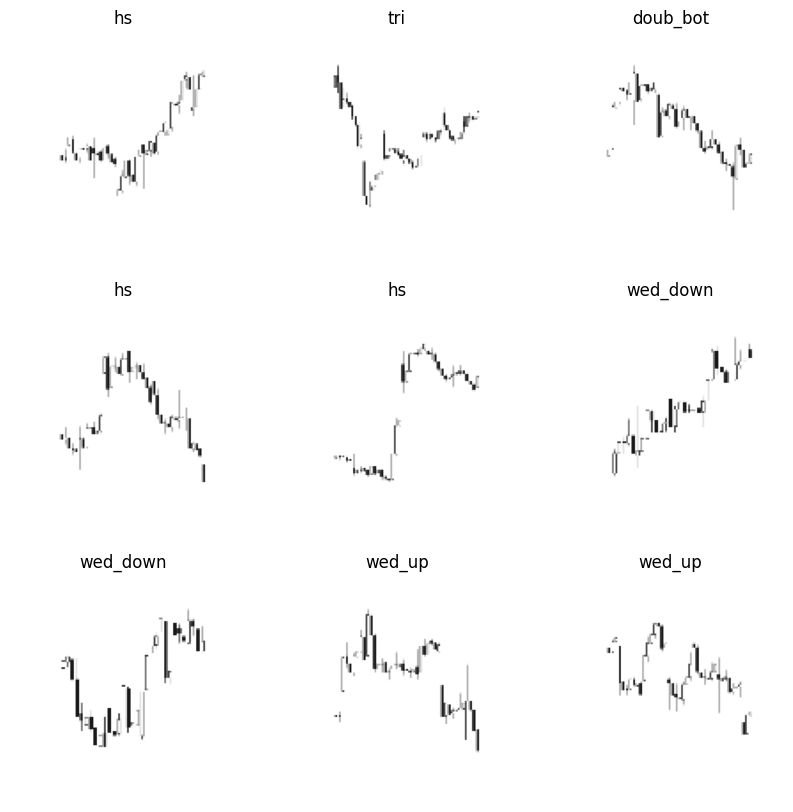

In [159]:
# Test by printing first ten images from the training dateset
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [160]:
# Create a test set
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 896
Number of test batches: 224


In [161]:
# Rescale the images from [-1 to 1] vs [0 to 255]
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [162]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [163]:
# This feature extractor converts each 255x255 image into a 5x5x1280 block of features
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 4, 4, 1280)


### Feature extraction step
- beginning by freezing the the weights. Return to this later.
- https://www.tensorflow.org/guide/keras/transfer_learning

In [165]:
base_model.trainable = False

In [166]:
# Adding a classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [167]:
# Add a dense layer to convert it to a single prediction per image
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [169]:
# Train the model on our inputs
inputs = tf.keras.Input(shape=(128, 128, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [171]:
# We use binary accuracy here because of the Sigmoid?
# If we use a different activator then I am not sure 
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['binary_accuracy'])
              # metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='binary_accuracy')])

In [172]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

896/896 ━━━━━━━━━━━━━━━━━━━━ 98s 106ms/step - binary_accuracy: 0.1128 - loss: -1.1247


In [173]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: -1.14
initial accuracy: 0.11


In [174]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 362s 137ms/step - binary_accuracy: 0.1132 - loss: -90.4896 - val_binary_accuracy: 0.1134 - val_loss: -358.1064
Epoch 2/10
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 362s 139ms/step - binary_accuracy: 0.1137 - loss: -447.4375 - val_binary_accuracy: 0.1134 - val_loss: -715.1071
Epoch 3/10
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 372s 142ms/step - binary_accuracy: 0.1137 - loss: -804.6531 - val_binary_accuracy: 0.1134 - val_loss: -1072.7905
Epoch 4/10
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 369s 141ms/step - binary_accuracy: 0.1137 - loss: -1162.9801 - val_binary_accuracy: 0.1134 - val_loss: -1430.7736
Epoch 5/10
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 370s 141ms/step - binary_accuracy: 0.1137 - loss: -1519.4254 - val_binary_accuracy: 0.1134 - val_loss: -1787.8984
Epoch 6/10
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 376s 144ms/step - binary_accuracy: 0.1137 - loss: -1876.4369 - val_binary_accuracy: 0.1134 - val_loss: -2144.3235
Epoch 7/10
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 374s 143ms/step - binary_acc

In [176]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

KeyError: 'val_accuracy'

In [177]:
base_model.trainable = True

In [179]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [181]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='binary_accuracy')])

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 11/20
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 610s 231ms/step - binary_accuracy: 0.1137 - loss: -3133.7361 - val_binary_accuracy: 0.1134 - val_loss: -9610.4375
Epoch 12/20
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 596s 228ms/step - binary_accuracy: 0.1137 - loss: -5369.3193 - val_binary_accuracy: 0.1134 - val_loss: -7980.6968
Epoch 13/20
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 584s 224ms/step - binary_accuracy: 0.1137 - loss: -5601.6021 - val_binary_accuracy: 0.1134 - val_loss: -6885.0200
Epoch 14/20
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 580s 222ms/step - binary_accuracy: 0.1137 - loss: -5809.5479 - val_binary_accuracy: 0.1134 - val_loss: -6653.2480
Epoch 15/20
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 587s 225ms/step - binary_accuracy: 0.1137 - loss: -6008.6069 - val_binary_accuracy: 0.1134 - val_loss: -6609.5220
Epoch 16/20
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 555s 213ms/step - binary_accuracy: 0.1137 - loss: -6207.2227 - val_binary_accuracy: 0.1134 - val_loss: -6419.8721
Epoch 17/20
2613/2613 ━━━━━━━━━━━━━━━━━━━━ 550s 210ms/step